<a href="https://colab.research.google.com/github/arnavsinghal09/GSoC-QMAML/blob/main/QMAML_Quark_Gluon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pennylane --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 51.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 61.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 94.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 90.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 120.3 MB/s eta 0:00:00


In [29]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
import pennylane as qml
from pennylane import numpy as npq
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
import h5py
import numpy as np
import random
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt

In [32]:
# 2. Hyperparameters

DATA_DIR = "/content/drive/MyDrive/quark-gluon-dataset"
FILES = [
    "quark-gluon_train-set_n793900.hdf5",
    "quark-gluon_test-set_n139306.hdf5",
    "quark-gluon_test-set_n10000.hdf5"
]
FILE_PATHS = [f"{DATA_DIR}/{fname}" for fname in FILES]

BATCH_SIZE = 16
LEARNING_RATE = 2e-3
EPOCHS = 10
N_QUBITS = 5                # Number of qubits/features per sample
N_LAYERS = 3                # Quantum circuit layers
K_SHOT = 16
K_QUERY = 32
META_BATCH_SIZE = 4
INNER_STEPS = 8
INNER_LR = 0.15

In [33]:
# 3. Data Preparation and Meta-Task Binning

with h5py.File(FILE_PATHS[0], "r") as f:
    X = np.array(f["X_jets"][:1024])  # Use a manageable subset for quantum
    y = np.array(f["y"][:1024])
    pt = np.array(f["pt"][:1024])
    m0 = np.array(f["m0"][:1024])

# Use mean of each channel as features, add pt and m0, use only N_QUBITS features
X_feat = np.stack([X[:,:,:,i].mean(axis=(1,2)) for i in range(3)], axis=1)
X_feat = np.concatenate([X_feat, pt[:,None], m0[:,None]], axis=1)
X_feat = X_feat[:,:N_QUBITS]

# Jet mass bins
mass_bins = np.percentile(m0, np.linspace(0, 100, 6))
print("Jet mass bins:", mass_bins)
# pT bins
pt_bins = np.percentile(pt, np.linspace(0, 100, 6))
print("pT bins:", pt_bins)

Jet mass bins: [ 8.03896046 15.89088192 19.0174366  21.82292747 26.1563942  47.21038055]
pT bins: [ 70.55924225  95.97884979 107.36923523 118.13747101 134.59178467
 265.02752686]


In [34]:
# 4. Quantum Dataset Class with Meta-Task Binning

class QuantumJetDataset(Dataset):
    def __init__(self, X, y, bin_var=None, bins=None):
        self.X = X
        self.y = y
        self.bin_var = bin_var
        self.bins = bins
        if self.bin_var is not None and self.bins is not None:
            self.bin_indices = []
            for i in range(len(bins) - 1):
                idx = np.where((bin_var >= bins[i]) & (bin_var < bins[i+1]))[0]
                self.bin_indices.append(idx)
        else:
            self.bin_indices = [np.arange(len(y))]
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        x = self.X[idx]
        label = int(self.y[idx])
        return torch.tensor(x, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

In [35]:
# 5. Quantum Data Encoding Function

def angle_encoding(x, wires):
    for i in range(len(x)):
        qml.RY(x[i], wires=wires[i])

In [36]:
# 6. Quantum Circuit and Hybrid Model

dev = qml.device("default.qubit", wires=N_QUBITS)

@qml.qnode(dev, interface="torch")
def quantum_circuit(inputs, weights):
    angle_encoding(inputs, wires=range(N_QUBITS))
    for l in range(N_LAYERS):
        for i in range(N_QUBITS):
            qml.RY(weights[l, i, 0], wires=i)
            qml.RZ(weights[l, i, 1], wires=i)
        for i in range(N_QUBITS-1):
            qml.CNOT(wires=[i, i+1])
    return [qml.expval(qml.PauliZ(i)) for i in range(N_QUBITS)]

class QuantumNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.q_weights = nn.Parameter(torch.randn(N_LAYERS, N_QUBITS, 2) * 0.01)
        self.fc = nn.Linear(N_QUBITS, 2)  # 2 classes
    def forward(self, x, q_weights=None, fc_weight=None, fc_bias=None):
        q_weights = q_weights if q_weights is not None else self.q_weights
        fc_weight = fc_weight if fc_weight is not None else self.fc.weight
        fc_bias = fc_bias if fc_bias is not None else self.fc.bias
        q_out = []
        for i in range(x.shape[0]):
            qc_out = quantum_circuit(x[i], q_weights)
            if not isinstance(qc_out, torch.Tensor):
                qc_out = torch.tensor(qc_out, dtype=torch.float32)
            qc_out = qc_out.to(fc_weight.device)
            q_out.append(qc_out)
        q_out = torch.stack(q_out)
        x = nn.functional.linear(q_out, fc_weight, fc_bias)
        return x

In [37]:
# 7. Task Sampler for Meta-Learning

def sample_task(dataset, bin_idx, k_shot, k_query):
    idxs = dataset.bin_indices[bin_idx]
    idxs = np.random.permutation(idxs)
    support_idxs = idxs[:k_shot]
    query_idxs = idxs[k_shot:k_shot + k_query]
    X_s, y_s = zip(*[dataset[i] for i in support_idxs])
    X_q, y_q = zip(*[dataset[i] for i in query_idxs])
    return (torch.stack(X_s), torch.tensor(y_s)), (torch.stack(X_q), torch.tensor(y_q))

In [38]:
# 8. MAML Training Loop (Quantum, with Stats)

def maml_train_q(model, dataset, bins, meta_batch_size=META_BATCH_SIZE, epochs=EPOCHS):
    model = model  # No .to(DEVICE) since quantum_circuit runs on CPU
    meta_optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    loss_fn = nn.CrossEntropyLoss()
    stats = {"loss": [], "acc": [], "f1": [], "prec": [], "rec": []}
    for epoch in range(epochs):
        meta_loss = 0
        all_y_true, all_y_pred = [], []
        for _ in range(meta_batch_size):
            bin_idx = random.randint(0, len(bins)-2)
            (X_s, y_s), (X_q, y_q) = sample_task(dataset, bin_idx, K_SHOT, K_QUERY)
            q_weights = model.q_weights
            fc_weight = model.fc.weight
            fc_bias = model.fc.bias
            for _ in range(INNER_STEPS):
                logits = model(X_s, q_weights, fc_weight, fc_bias)
                loss = loss_fn(logits, y_s)
                grads = torch.autograd.grad(loss, [q_weights, fc_weight, fc_bias], create_graph=True, allow_unused=True)
                q_weights = q_weights - INNER_LR * (grads[0] if grads[0] is not None else torch.zeros_like(q_weights))
                fc_weight = fc_weight - INNER_LR * (grads[1] if grads[1] is not None else torch.zeros_like(fc_weight))
                fc_bias = fc_bias - INNER_LR * (grads[2] if grads[2] is not None else torch.zeros_like(fc_bias))
            logits_q = model(X_q, q_weights, fc_weight, fc_bias)
            loss_q = loss_fn(logits_q, y_q)
            meta_loss += loss_q
            preds = logits_q.argmax(dim=1)
            all_y_true.append(y_q)
            all_y_pred.append(preds)
        meta_optimizer.zero_grad()
        meta_loss.backward()
        meta_optimizer.step()
        all_y_true = torch.cat(all_y_true)
        all_y_pred = torch.cat(all_y_pred)
        acc = accuracy_score(all_y_true.cpu().numpy(), all_y_pred.cpu().numpy())
        f1 = f1_score(all_y_true.cpu().numpy(), all_y_pred.cpu().numpy())
        prec = precision_score(all_y_true.cpu().numpy(), all_y_pred.cpu().numpy())
        rec = recall_score(all_y_true.cpu().numpy(), all_y_pred.cpu().numpy())
        stats["loss"].append(meta_loss.item()/meta_batch_size)
        stats["acc"].append(acc)
        stats["f1"].append(f1)
        stats["prec"].append(prec)
        stats["rec"].append(rec)
        print(f"Epoch {epoch+1:2d} | Meta Loss: {meta_loss.item()/meta_batch_size:.4f} | "
              f"Acc: {acc:.4f} | F1: {f1:.4f} | Prec: {prec:.4f} | Rec: {rec:.4f}")
    return model, stats

In [39]:
# 9. Instantiate Datasets for Both Meta-Tasks

qjet_dataset_mass = QuantumJetDataset(X_feat, y, bin_var=m0, bins=mass_bins)
qjet_dataset_pt = QuantumJetDataset(X_feat, y, bin_var=pt, bins=pt_bins)

In [40]:
# 10. Train Quantum MAML on Jet Mass Meta-Tasks

q_maml_model_mass = QuantumNet()
q_maml_model_mass, stats_mass = maml_train_q(q_maml_model_mass, qjet_dataset_mass, mass_bins)

Epoch  1 | Meta Loss: 0.6602 | Acc: 0.5938 | F1: 0.1034 | Prec: 0.5000 | Rec: 0.0577
Epoch  2 | Meta Loss: 0.7018 | Acc: 0.5703 | F1: 0.5133 | Prec: 0.5800 | Rec: 0.4603
Epoch  3 | Meta Loss: 0.7109 | Acc: 0.5781 | F1: 0.7188 | Prec: 0.5798 | Rec: 0.9452
Epoch  4 | Meta Loss: 0.6771 | Acc: 0.5625 | F1: 0.6216 | Prec: 0.6765 | Rec: 0.5750
Epoch  5 | Meta Loss: 0.6558 | Acc: 0.6250 | F1: 0.2727 | Prec: 0.3913 | Rec: 0.2093
Epoch  6 | Meta Loss: 0.6695 | Acc: 0.5703 | F1: 0.2667 | Prec: 0.3704 | Rec: 0.2083
Epoch  7 | Meta Loss: 0.6970 | Acc: 0.6172 | F1: 0.7293 | Prec: 0.6111 | Rec: 0.9041
Epoch  8 | Meta Loss: 0.6564 | Acc: 0.6484 | F1: 0.5794 | Prec: 0.6078 | Rec: 0.5536
Epoch  9 | Meta Loss: 0.6787 | Acc: 0.5625 | F1: 0.0667 | Prec: 0.1250 | Rec: 0.0455
Epoch 10 | Meta Loss: 0.6980 | Acc: 0.5312 | F1: 0.5588 | Prec: 0.5067 | Rec: 0.6230


In [41]:
# 11. Train Quantum MAML on pT Meta-Tasks

q_maml_model_pt = QuantumNet()
q_maml_model_pt, stats_pt = maml_train_q(q_maml_model_pt, qjet_dataset_pt, pt_bins)

Epoch  1 | Meta Loss: 0.7253 | Acc: 0.4688 | F1: 0.3462 | Prec: 0.4000 | Rec: 0.3051
Epoch  2 | Meta Loss: 0.6944 | Acc: 0.5234 | F1: 0.5906 | Prec: 0.5789 | Rec: 0.6027
Epoch  3 | Meta Loss: 0.6564 | Acc: 0.6328 | F1: 0.5053 | Prec: 0.5854 | Rec: 0.4444
Epoch  4 | Meta Loss: 0.7144 | Acc: 0.4688 | F1: 0.5072 | Prec: 0.5224 | Rec: 0.4930
Epoch  5 | Meta Loss: 0.6987 | Acc: 0.5625 | F1: 0.6923 | Prec: 0.5478 | Rec: 0.9403
Epoch  6 | Meta Loss: 0.7213 | Acc: 0.5469 | F1: 0.5606 | Prec: 0.5781 | Rec: 0.5441
Epoch  7 | Meta Loss: 0.7407 | Acc: 0.4531 | F1: 0.4444 | Prec: 0.4912 | Rec: 0.4058
Epoch  8 | Meta Loss: 0.6974 | Acc: 0.5234 | F1: 0.6065 | Prec: 0.5222 | Rec: 0.7231
Epoch  9 | Meta Loss: 0.8207 | Acc: 0.4219 | F1: 0.5542 | Prec: 0.5000 | Rec: 0.6216
Epoch 10 | Meta Loss: 0.6777 | Acc: 0.5625 | F1: 0.6164 | Prec: 0.6000 | Rec: 0.6338


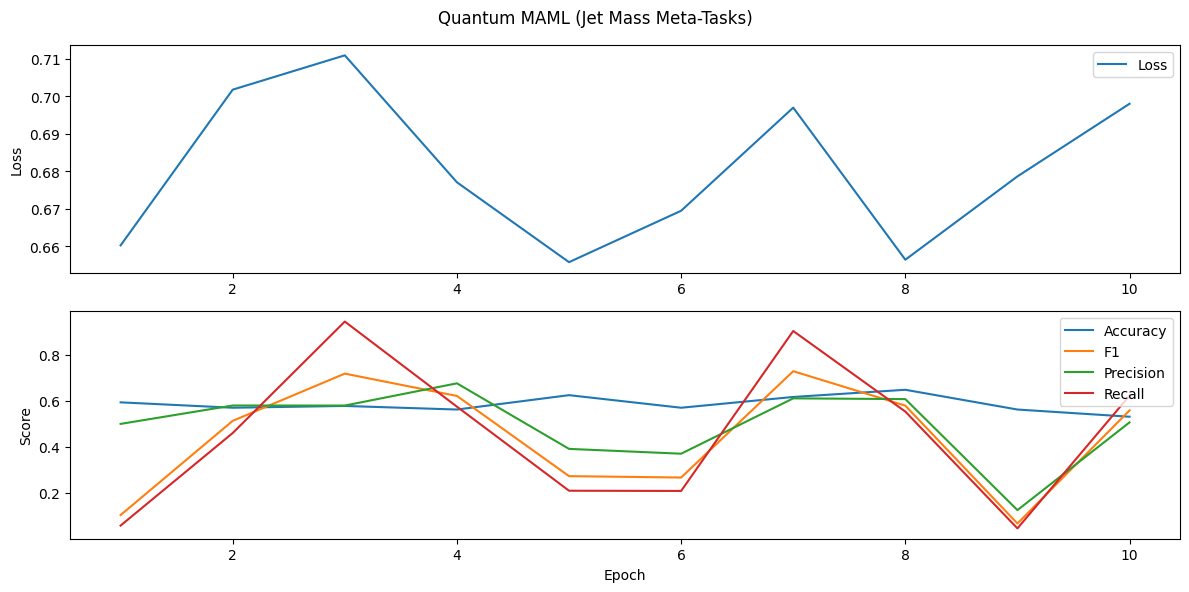

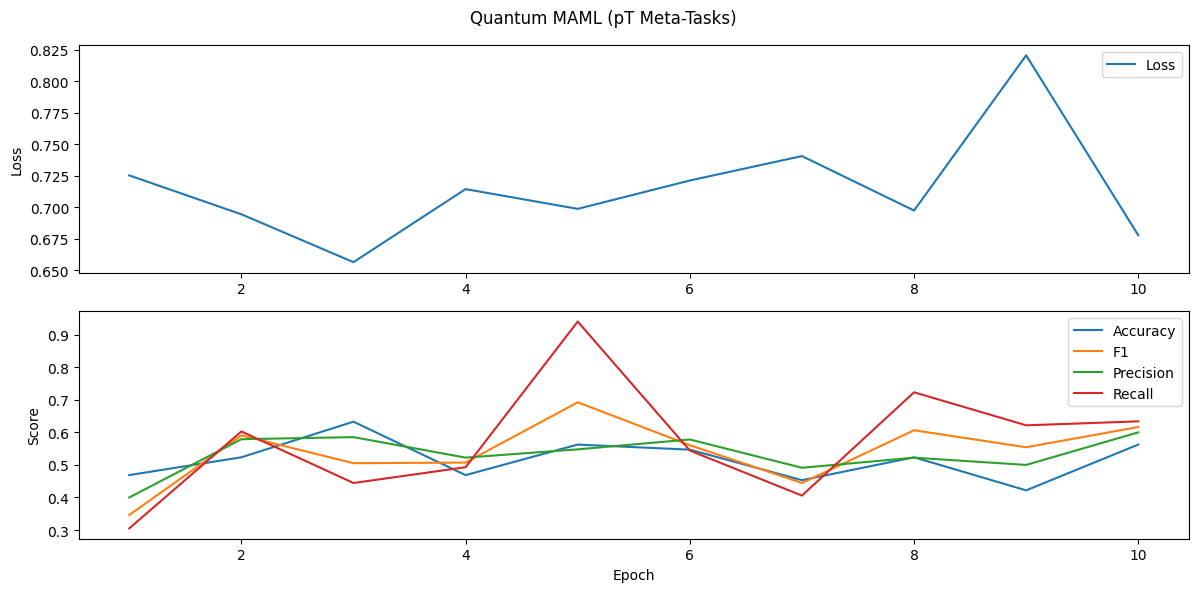

In [42]:
# 12. Plot Training Statistics

def plot_stats(stats, title="Quantum MAML Training Stats"):
    epochs = range(1, len(stats["loss"])+1)
    plt.figure(figsize=(12,6))
    plt.subplot(2,1,1)
    plt.plot(epochs, stats["loss"], label="Loss")
    plt.ylabel("Loss")
    plt.legend()
    plt.subplot(2,1,2)
    plt.plot(epochs, stats["acc"], label="Accuracy")
    plt.plot(epochs, stats["f1"], label="F1")
    plt.plot(epochs, stats["prec"], label="Precision")
    plt.plot(epochs, stats["rec"], label="Recall")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.legend()
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

plot_stats(stats_mass, title="Quantum MAML (Jet Mass Meta-Tasks)")
plot_stats(stats_pt, title="Quantum MAML (pT Meta-Tasks)")

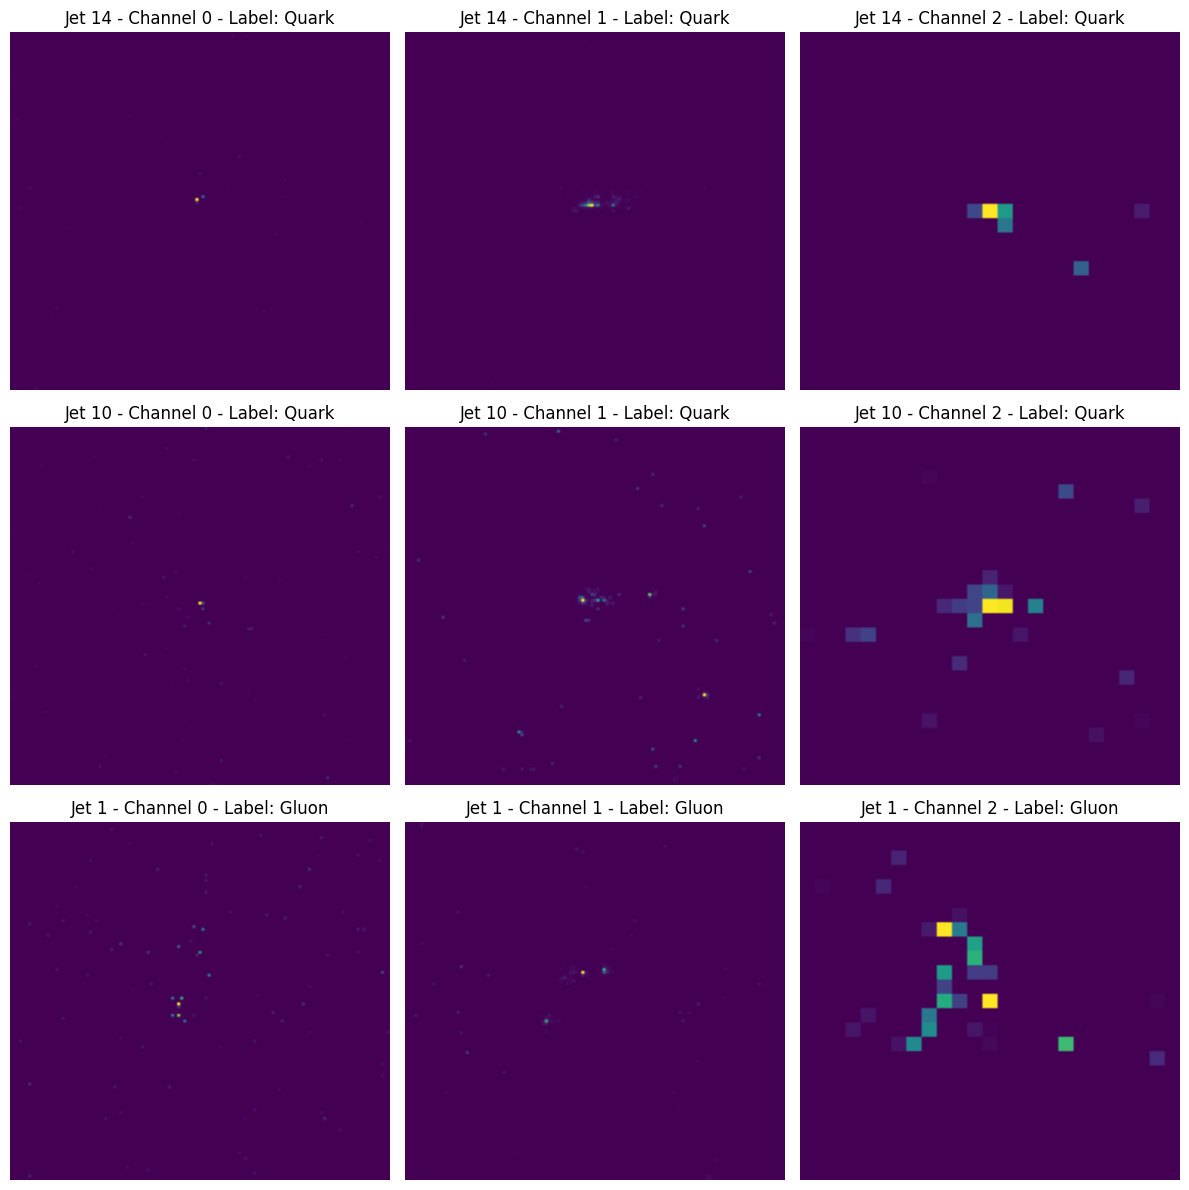

In [44]:
# 13. Visualize Jet Images

def plot_jet_images(X, y, n=3):
    plt.figure(figsize=(12,4*n))
    for i in range(n):
        idx = np.random.randint(0, len(X))
        for ch in range(3):
            plt.subplot(n, 3, i*3+ch+1)
            plt.imshow(X[idx,:,:,ch], aspect='auto', cmap='viridis')
            plt.title(f"Jet {idx} - Channel {ch} - Label: {'Quark' if y[idx]==0 else 'Gluon'}")
            plt.axis('off')
    plt.tight_layout()
    plt.show()

with h5py.File(FILE_PATHS[0], "r") as f:
    X_img = np.array(f["X_jets"][:20])
    y_img = np.array(f["y"][:20])
plot_jet_images(X_img, y_img, n=3)